In [3]:
!pip install tensorflow_hub

     ------------------------------------ 108.8/108.8 kB 573.1 kB/s eta 0:00:00


In [4]:
# установка необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv
from pathlib import Path

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# вывод графика и сохранение в ноутбуке
%matplotlib inline

In [ ]:
tf.__version__

'2.6.4'

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
N_CLASSES = 9

In [6]:
# загрузка обученной модели vit_b8_fe
model_vit_b8_fe = keras.models.load_model('vit_b8_fe_1')
model_vit_b8_fe.trainable = False # замораживаем всю базовую модель
variables = model_vit_b8_fe.signatures["serving_default"].trainable_variables
for i in range(len(variables)):
    variables[i]._handle_name = variables[i].name.replace('0', str(i))

In [7]:
variables[197].name

'Variable:197'

In [24]:
# создание модели с дополнительными слоями для решения моей задачи
model = tf.keras.Sequential([
            tf.keras.layers.InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3)),
            hub.KerasLayer(model_vit_b8_fe),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(N_CLASSES)
                            ]
                            )
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 768)               85807872  
                                                                 
 dense_4 (Dense)             (None, 512)               393728    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 86,206,217
Trainable params: 398,345
Non-trainable params: 85,807,872
_________________________________________________________________


In [9]:
# загрузка обучающего и валидационного датафреймов из csv-файлов
train_df = pd.read_csv('train_df.csv', index_col = 0) 
test_df = pd.read_csv('test_df.csv', index_col = 0)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40037 entries, 46357 to 14269
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  40037 non-null  object
 1   emotion     40037 non-null  object
dtypes: object(2)
memory usage: 938.4+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 2 to 50040
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10009 non-null  object
 1   emotion     10009 non-null  object
dtypes: object(2)
memory usage: 234.6+ KB


In [ ]:
# функция препроцессинга
def preprocess(img):
    image = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    image = (image - 127.5) / 127.5
    return image

In [ ]:
# генератор обучающих данных с функцией аугментации
train_generator = ImageDataGenerator(
                                     rotation_range=15,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.1,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess
                                     )
        
train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col='image_path',
                                                     y_col='emotion',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='sparse',
                                                     shuffle=True,
                                                     interpolation='nearest',
                                                    )

# генератор валидационных данных
val_generator = ImageDataGenerator(preprocessing_function=preprocess)

val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='image_path',
                                                 y_col='emotion',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 shuffle=False,
                                                 interpolation='nearest',
                                                )

Found 40037 validated image filenames belonging to 9 classes.
Found 10009 validated image filenames belonging to 9 classes.


In [25]:
# создание папки модели и имени файла для записи весов во время обучения
path = Path('model_vit_b8_fe')
path.mkdir(exist_ok=True, parents=True) # папка создается на диске вместе с "родителями"
assert path.exists()
cpt_filename = 'best_checkpoint.hdf5'  
cpt_path = str(path / cpt_filename)

In [ ]:
# обратный вызов для сохранения весов модели
checkpoint = ModelCheckpoint(cpt_path,
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=True,
                            save_freq='epoch',
                            mode='min')

In [26]:
# функция экспоненциального затухания к шагу оптимизатора с заданной начальной скоростью обучения
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=100,
    decay_rate=0.9)

# настройка модели для обучения
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

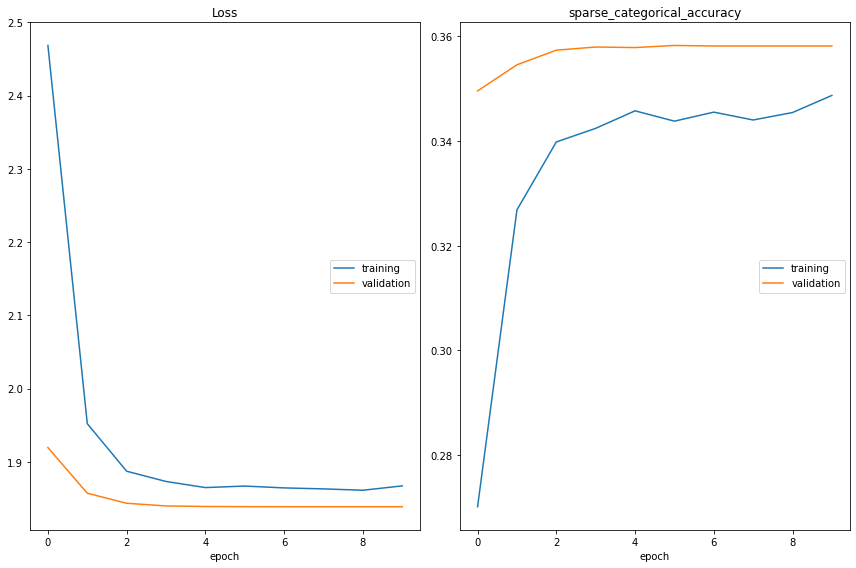

Loss
	training         	 (min:    1.861, max:    2.469, cur:    1.867)
	validation       	 (min:    1.839, max:    1.919, cur:    1.839)
sparse_categorical_accuracy
	training         	 (min:    0.270, max:    0.349, cur:    0.349)
	validation       	 (min:    0.350, max:    0.358, cur:    0.358)


In [ ]:
# обучение модели
EPOCHS = 10
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[checkpoint,
                               PlotLossesCallback()
                              ]
                    )

In [ ]:
# значение потерь и значения метрики для модели в тестовом режиме
model.evaluate(val_data_gen)

313/313 [==============================] - 371s 1s/step - loss: 1.8387 - sparse_categorical_accuracy: 0.3582


[1.8387013673782349, 0.35817763209342957]

In [31]:
# запись весов модели
model.save_weights('model_vit_b8_fe/weights.h5')

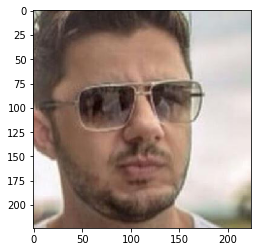

In [ ]:
# случайный выбор и обработка изображения для теста
rng = np.random.default_rng()
n = rng.integers(5000, size=1)[0]
img = image.load_img('test_kaggle/' + str(n) + '.jpg', target_size=(224, 224))
x = image.img_to_array(img, dtype=np.uint8)
x = np.expand_dims(x, axis=0)
plt.imshow(img)

In [ ]:
# определение времени инференса сети
%%timeit 
#-n 10 -r 10

model.predict(preprocess(x))

78.7 ms ± 8.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
# создание словаря эмоций из файла
def load_dict_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

emotion_mapping = load_dict_from_file('dict.txt')
emotion_mapping

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [ ]:
# определение эмоции на тестовом изображении
predicted = model.predict(preprocess(x))
emotion_mapping[np.argmax(predicted)]

'uncertain'

In [ ]:
# создание списка для структруированного по заданию итогового csv-файла из файла
def load_list_from_file(path):
    f = open(path,'r')
    data=f.read()
    f.close()
    return eval(data)

my_list = load_list_from_file('test_list.txt')

In [ ]:
# запись итогового csv-файла
with open('submission_vit_b8_fe.csv', 'w') as f:
    fieldnames = ['image_path', 'emotion']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for name in my_list:
        img = image.load_img('test_kaggle/'+ name, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        predicted_arr = model.predict(preprocess(x))
        predicted = emotion_mapping[np.argmax(predicted_arr)]
        # test_dict[name.replace('test_kaggle/', '')] = predicted
        writer.writerow({'image_path': name.replace('test_kaggle/', ''), 'emotion': predicted})

### Оценки Kaggle

Score: 0.35120

Public score: 0.36000